# Intro to ANN
1. You are provided with an encoded hash, **lfkmq]ofiegoU~eUCEKCw**, along with four different models and their associated output embedding spaces. 
2. Each model takes an input of size 26, the highest value of all represents the corresponding english alphabet according to alphabetic sequence. 
3. Your goal is to reverse engineer the 4 alphabets from the models and their embedding spaces, then use it as a key to XOR with the encoded hash and get the final flag.

*Note: hash XOR _ _ _ _ = flag{fake_flag}

In [ ]:
#make sure pytorch version matches, and don't use gpu for seed to match
# !pip install torch==2.3.0+cu121

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
from tqdm import tqdm

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.manual_seed(42)

In [3]:
out1, out2, out3, out4 = torch.load("outputs.pkl")

In [11]:
def plot_alphabet(ten):
    chars = list("abcdefghijklmnopqrstuvwxyz")
    nums = range(26)
    vals = ten.tolist()
    
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.bar(nums, vals)
    ax.set_xticks(nums, labels=chars)
    plt.show()

## ANN

In [4]:
class SimpleANN(nn.Module):
    def __init__(self, input_size=26, hidden_size=64, output_size=50):
        super(SimpleANN, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input to hidden layer
        self.relu = nn.ReLU()                         # Activation function
        self.fc2 = nn.Linear(hidden_size, output_size) # Hidden layer to output

        # Initialize weights with a specific random seed
        self._initialize_weights()

    def _initialize_weights(self):
        # Initialize weights with random values
        nn.init.normal_(self.fc1.weight, mean=0.0, std=0.02)  # Normal distribution for fc1
        nn.init.normal_(self.fc2.weight, mean=0.0, std=0.02)  # Normal distribution for fc2

        # Initialize biases to zero (optional)
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.constant_(self.fc2.bias, 0.0)

    def forward(self, x):
        # Forward pass
        x = self.fc1(x)  # Input layer to hidden layer
        x = self.relu(x) # Activation function
        x = self.fc2(x)  # Hidden layer to output layer
        return x

In [5]:
model = SimpleANN()
model.eval();
in_ten = nn.Parameter(data=torch.randn((26,), dtype=torch.float32))

In [6]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=[in_ten], lr=3e-1)

/home/tnwei/miniconda3/envs/ioai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
metrics = []
for i in tqdm(range(10_000)):
    out = model(in_ten)
    loss = loss_fn(out, out1)
    loss.backward()
    
    metrics.append(loss.item())
    
    optimizer.step()
    optimizer.zero_grad()

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1574.74it/s]


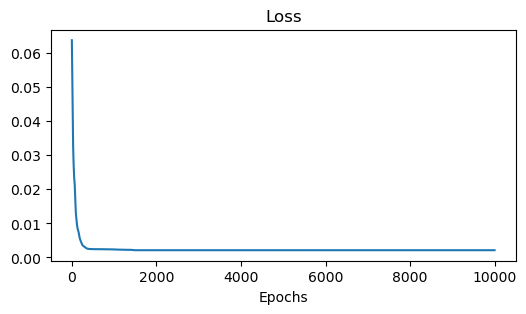

In [10]:
plt.figure(figsize=(6, 3))
plt.plot(metrics)
plt.title("Loss")
plt.xlabel("Epochs")
plt.show()

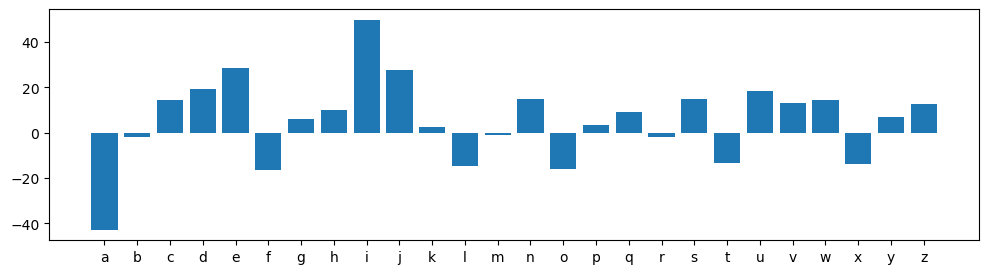

In [12]:
plot_alphabet(in_ten)

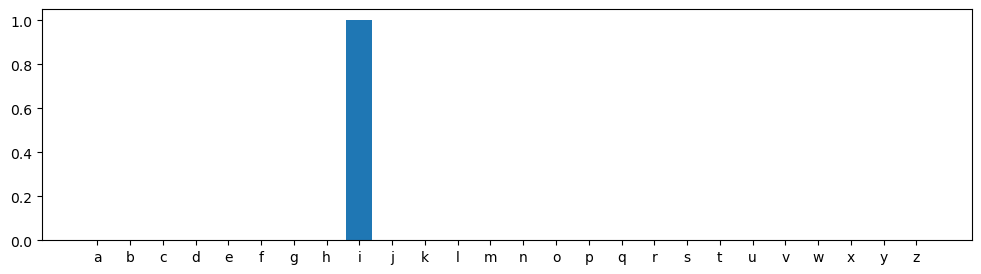

In [17]:
plot_alphabet(F.softmax(in_ten, dim=0))

In [13]:
# Best optimized answer
with torch.no_grad():
    print(loss_fn(model(in_ten), out1))

tensor(0.0021)


In [14]:
i_data = torch.zeros((26,), dtype=torch.float32)
i_data[8] = 100 #correct alphabet index will be as large as possible, the rest 0

In [15]:
# Actual answer
with torch.no_grad():
    print(loss_fn(model(i_data), out1))

tensor(0.)


## second alphabet - RNN

In [20]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size=26, hidden_size=64, output_size=50, num_layers=1):
        super(SimpleRNN, self).__init__()
        
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layer for the output
        self.fc = nn.Linear(hidden_size, output_size)

        # Initialize weights with a specific random seed
        self._initialize_weights()

    def _initialize_weights(self):
        # Custom weight initialization for reproducibility
        torch.manual_seed(42)

        # Initialize RNN weights
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                nn.init.kaiming_normal_(param, mode='fan_out', nonlinearity='relu')
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)

        # Initialize fully connected layer weights
        nn.init.xavier_uniform_(self.fc.weight)  # Xavier initialization for fc layer
        nn.init.constant_(self.fc.bias, 0.0)     # Set biases to zero

    def forward(self, x, hidden):
        # Forward pass through RNN
        out, hidden = self.rnn(x, hidden)  # RNN layer
        out = self.fc(out[:, -1, :])       # Fully connected layer (take last time step's output)
        return out, hidden

In [21]:
hidden_size = 64  # Hidden state size
batch_size = 1        # Batch size
num_layers = 1        # Number of RNN layers
hidden = torch.zeros(num_layers, batch_size, hidden_size)

model = SimpleRNN()
model.eval();

in_ten = nn.Parameter(data=torch.randn((1, 1, 26,), dtype=torch.float32))

In [22]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=[in_ten], lr=3e-1)

In [23]:
metrics = []
for i in tqdm(range(10_000)):
    out, _ = model(in_ten, hidden)
    loss = loss_fn(out, out2)
    loss.backward()
    
    metrics.append(loss.item())
    
    optimizer.step()
    optimizer.zero_grad()

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1215.08it/s]


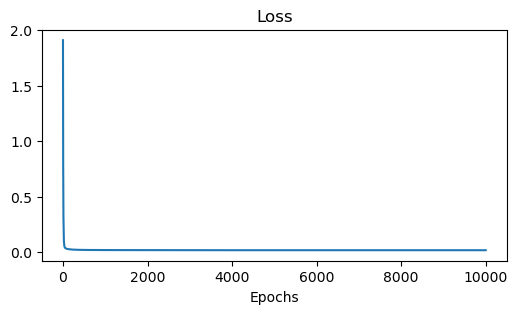

In [24]:
plt.figure(figsize=(6, 3))
plt.plot(metrics)
plt.title("Loss")
plt.xlabel("Epochs")
plt.show()

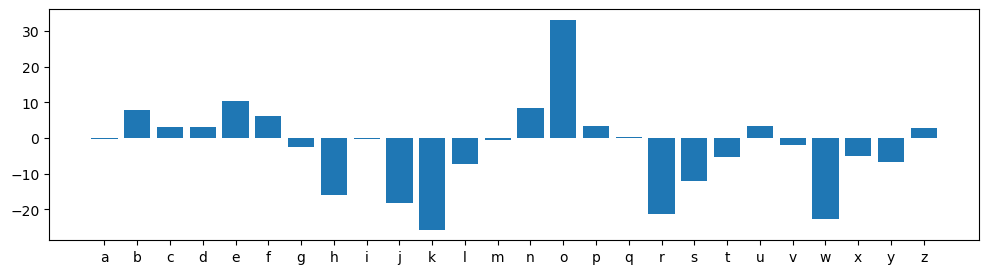

In [26]:
plot_alphabet(in_ten[0][0])

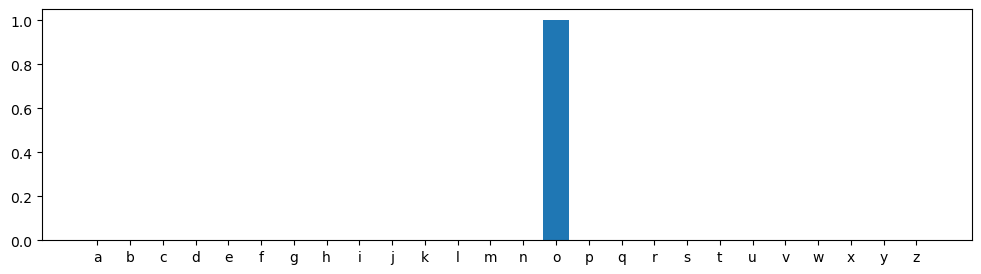

In [27]:
plot_alphabet(F.softmax(in_ten[0][0], dim=0))

## MLP

In [28]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size=26, hidden_size=64, output_size=50):
        super(SimpleMLP, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input to hidden layer
        self.fc2 = nn.Linear(hidden_size, hidden_size) # Hidden layer to hidden layer
        self.fc3 = nn.Linear(hidden_size, output_size)  # Hidden layer to output layer
        self.relu = nn.ReLU()  # Activation function
        
        # Initialize weights with a specific random seed
        self._initialize_weights()

    def _initialize_weights(self):
        # Custom weight initialization for reproducibility
        torch.manual_seed(42)  # Optional: redundant if already set globally

        # Initialize fully connected layer weights with Xavier (Glorot) initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        
        # Initialize biases to zero for fc layers
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.constant_(self.fc2.bias, 0.0)
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, x):
        # Forward pass
        x = self.fc1(x)        # Input layer to first hidden layer
        x = self.relu(x)       # ReLU activation
        x = self.fc2(x)        # First hidden layer to second hidden layer
        x = self.relu(x)       # ReLU activation
        x = self.fc3(x)        # Second hidden layer to output layer
        return x

In [29]:
model = SimpleMLP()
model.eval();

in_ten = nn.Parameter(data=torch.randn((26,), dtype=torch.float32))

In [30]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=[in_ten], lr=3e-1)

In [33]:
metrics = []
for i in tqdm(range(10_000)):
    out = model(in_ten)
    loss = loss_fn(out, out3)
    loss.backward()
    
    metrics.append(loss.item())
    
    optimizer.step()
    optimizer.zero_grad()

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1360.43it/s]


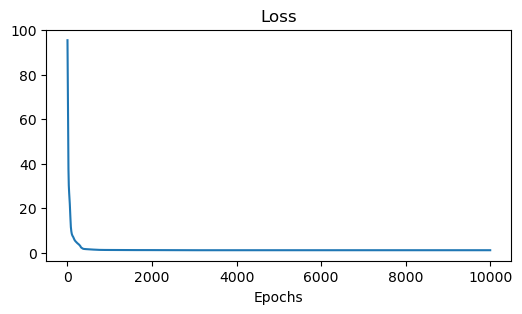

In [34]:
plt.figure(figsize=(6, 3))
plt.plot(metrics)
plt.title("Loss")
plt.xlabel("Epochs")
plt.show()

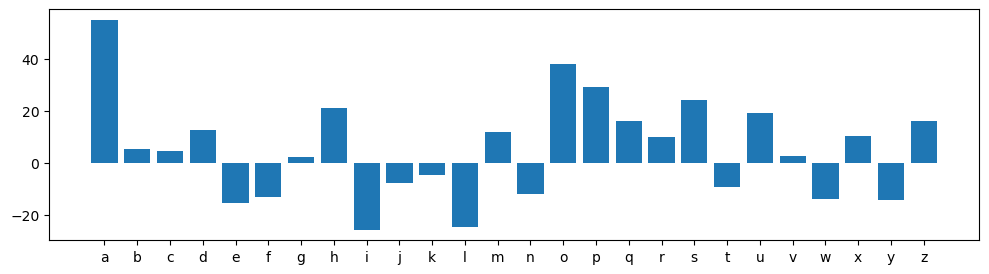

In [36]:
plot_alphabet(in_ten)

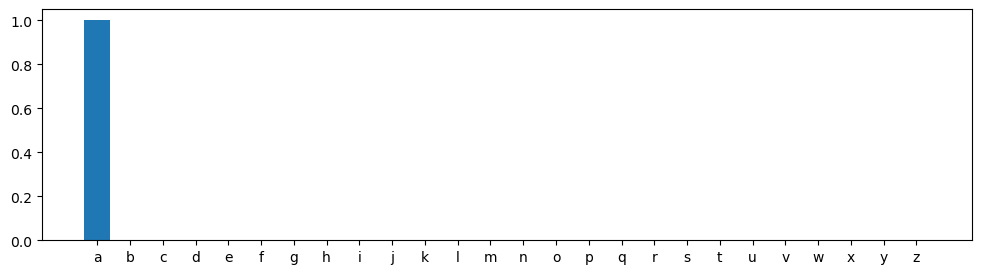

In [37]:
plot_alphabet(F.softmax(in_ten, dim=0))

## fourth alphabet - KAN

In [39]:
class SimpleKAN(nn.Module):
    def __init__(self, input_size=26, hidden_size=64, output_size=50):
        super(SimpleKAN, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input to hidden layer
        self.fc2 = nn.Linear(hidden_size, hidden_size) # Hidden layer to hidden layer
        self.fc3 = nn.Linear(hidden_size, output_size)  # Hidden layer to output layer
        self.relu = nn.ReLU()  # Activation function

        # Attention mechanism parameters
        self.attention = nn.Linear(hidden_size, hidden_size)  # Attention weights

        # Initialize weights with a specific random seed
        self._initialize_weights()

    def _initialize_weights(self):
        # Custom weight initialization for reproducibility
        torch.manual_seed(42)  # Optional: redundant if already set globally

        # Initialize fully connected layer weights with Xavier (Glorot) initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        
        # Initialize attention weights with Xavier initialization
        nn.init.xavier_uniform_(self.attention.weight)
        
        # Initialize biases to zero for fc layers
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.constant_(self.fc2.bias, 0.0)
        nn.init.constant_(self.fc3.bias, 0.0)
        nn.init.constant_(self.attention.bias, 0.0)

    def forward(self, x):
        # Forward pass
        x = self.fc1(x)            # Input layer to first hidden layer
        x = self.relu(x)           # ReLU activation
        x = self.fc2(x)            # First hidden layer to second hidden layer
        x = self.relu(x)           # ReLU activation

        # Apply attention mechanism
        attention_weights = self.attention(x)  # Attention mechanism
        x = x * attention_weights  # Apply attention weights

        x = self.fc3(x)            # Second hidden layer to output layer
        return x

In [40]:
model = SimpleKAN()
model.eval();

in_ten = nn.Parameter(data=torch.randn((26,), dtype=torch.float32))

In [41]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=[in_ten], lr=3e-1)

In [42]:
metrics = []
for i in tqdm(range(10_000)):
    out = model(in_ten)
    loss = loss_fn(out, out4)
    loss.backward()
    
    metrics.append(loss.item())
    
    optimizer.step()
    optimizer.zero_grad()

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1192.49it/s]


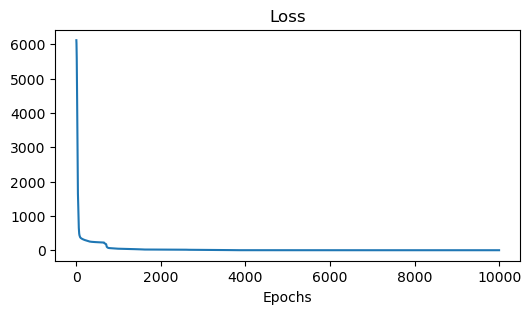

In [43]:
plt.figure(figsize=(6, 3))
plt.plot(metrics)
plt.title("Loss")
plt.xlabel("Epochs")
plt.show()

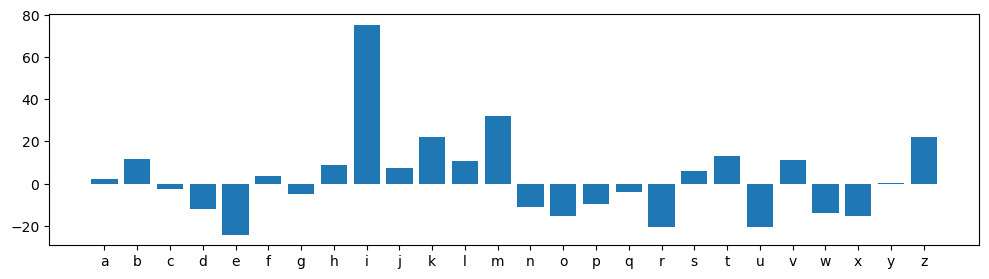

In [44]:
plot_alphabet(in_ten)

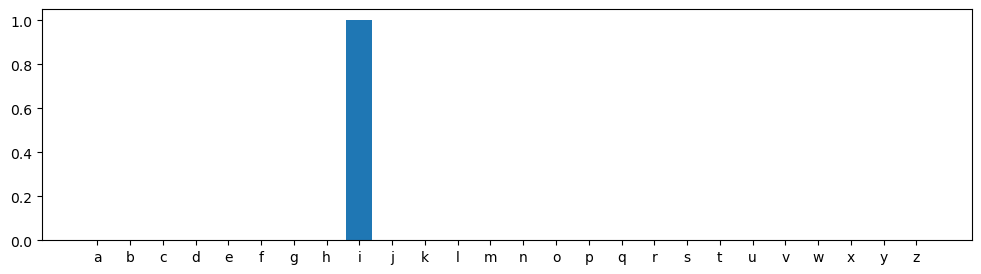

In [45]:
plot_alphabet(F.softmax(in_ten, dim=0))